In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
print("Loading travel card data...")
df = pd.read_csv('../separate_dfs/travel_card_data.csv')
df['date'] = pd.to_datetime(df['date'])

# Basic data info
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique clients: {df['client_code'].nunique()}")
print(f"Data sources: {df['data_source'].value_counts().to_dict()}")

# Fill missing demographic data at client level
print("\nFilling missing demographic data...")
for col in ['avg_monthly_balance_KZT', 'age', 'status', 'name', 'city']:
    if col in df.columns:
        df[col] = df.groupby('client_code')[col].transform('first')

# Display sample data
print("\nSample data:")
df.head()

Loading travel card data...
Dataset shape: (20907, 13)
Date range: 2025-06-01 08:00:35 to 2025-08-31 21:55:56
Unique clients: 57
Data sources: {'transfer': 14148, 'transaction': 6759}

Filling missing demographic data...

Sample data:


,client_code,name,status,age,city,avg_monthly_balance_KZT,date,data_source,type,category,direction,amount,currency
0,1,Айгерим,Зарплатный клиент,29.0,Алматы,92643.0,2025-06-01 09:10:36,transaction,NaN,Такси,NaN,6424.48,KZT
1,1,Айгерим,Зарплатный клиент,29.0,Алматы,92643.0,2025-06-01 09:15:49,transaction,NaN,Такси,NaN,2643.90,KZT
2,1,Айгерим,Зарплатный клиент,29.0,Алматы,92643.0,2025-06-01 11:40:16,transfer,card_out,NaN,out,9359.56,KZT
3,1,Айгерим,Зарплатный клиент,29.0,Алматы,92643.0,2025-06-01 15:40:10,transaction,NaN,Такси,NaN,3669.43,KZT
4,1,Айгерим,Зарплатный клиент,29.0,Алматы,92643.0,2025-06-02 13:10:59,transfer,card_out,NaN,out,17590.68,KZT


In [3]:
# Travel-Specific Feature Engineering
print("Creating travel-specific features...")

# 1. Travel spending categories (from product config)
travel_categories = ["Путешествия", "Отели", "Такси", "Кафе и рестораны", "Развлечения", "АЗС"]
print(f"Travel categories: {travel_categories}")

# Mark travel-related transactions
df['is_travel_spending'] = df['category'].isin(travel_categories).astype(int)

# 2. Travel transfer types (from product config filters)
travel_transfer_types = ["fx_buy", "fx_sell", "card_out", "card_in", "atm_withdrawal", "p2p_out"]
print(f"Travel transfer types: {travel_transfer_types}")

# Mark travel-related transfers
df['is_travel_transfer'] = df['type'].isin(travel_transfer_types).astype(int)

# 3. International activity indicators
df['is_fx_activity'] = df['type'].isin(['fx_buy', 'fx_sell']).astype(int)
df['is_atm_withdrawal'] = (df['type'] == 'atm_withdrawal').astype(int)

# 4. Direction-based features
df['is_inflow'] = ((df['data_source'] == 'transfer') & (df['direction'] == 'in')).astype(int)
df['is_outflow'] = ((df['data_source'] == 'transaction') | 
                    ((df['data_source'] == 'transfer') & (df['direction'] == 'out'))).astype(int)

# 5. Time-based features
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month'] = df['date'].dt.month
df['is_vacation_season'] = df['month'].isin([6, 7, 8, 12]).astype(int)  # Summer and winter holidays

# Check feature creation
print(f"\nFeature summary:")
print(f"Travel spending transactions: {df['is_travel_spending'].sum()}")
print(f"Travel transfers: {df['is_travel_transfer'].sum()}")
print(f"FX activities: {df['is_fx_activity'].sum()}")
print(f"Weekend activities: {df['is_weekend'].sum()}")

# Display sample with new features
travel_sample = df[df['is_travel_spending'] == 1].head()
print(f"\nSample travel spending transactions:")
travel_sample[['client_code', 'date', 'category', 'amount', 'is_travel_spending']].head()

Creating travel-specific features...
Travel categories: ['Путешествия', 'Отели', 'Такси', 'Кафе и рестораны', 'Развлечения', 'АЗС']
Travel transfer types: ['fx_buy', 'fx_sell', 'card_out', 'card_in', 'atm_withdrawal', 'p2p_out']

Feature summary:
Travel spending transactions: 6759
Travel transfers: 14148
FX activities: 270
Weekend activities: 6204

Sample travel spending transactions:


,client_code,date,category,amount,is_travel_spending
0,1,2025-06-01 09:10:36,Такси,6424.48,1
1,1,2025-06-01 09:15:49,Такси,2643.90,1
3,1,2025-06-01 15:40:10,Такси,3669.43,1
11,1,2025-06-04 11:50:37,Такси,5541.49,1
13,1,2025-06-04 17:00:58,Кафе и рестораны,5635.01,1


In [4]:
# Client-Level Feature Aggregation
print("Aggregating features to client level...")

# Create client-level features
client_features = []

for client_code in df['client_code'].unique():
    client_data = df[df['client_code'] == client_code].copy()
    
    features = {'client_code': client_code}
    
    # 1. Basic demographics
    features['age'] = client_data['age'].iloc[0] if not pd.isna(client_data['age'].iloc[0]) else 35
    features['avg_monthly_balance_KZT'] = client_data['avg_monthly_balance_KZT'].iloc[0]
    features['status'] = client_data['status'].iloc[0]
    
    # Encode status for modeling
    status_mapping = {
        'Премиальный клиент': 3,
        'Зарплатный клиент': 2, 
        'Стандартный клиент': 1,
        'Студент': 0
    }
    features['status_encoded'] = status_mapping.get(features['status'], 1)
    
    # 2. Travel spending features
    travel_spending = client_data[client_data['is_travel_spending'] == 1]
    features['travel_spending_total'] = travel_spending['amount'].sum()
    features['travel_spending_count'] = len(travel_spending)
    features['travel_spending_avg'] = travel_spending['amount'].mean() if len(travel_spending) > 0 else 0
    features['travel_spending_frequency'] = len(travel_spending) / len(client_data) if len(client_data) > 0 else 0
    
    # Individual category analysis
    for category in travel_categories:
        cat_spending = client_data[client_data['category'] == category]['amount'].sum()
        features[f'{category.lower().replace(" ", "_")}_spending'] = cat_spending
    
    # 3. Travel transfer features
    travel_transfers = client_data[client_data['is_travel_transfer'] == 1]
    features['travel_transfer_count'] = len(travel_transfers)
    features['travel_transfer_amount'] = travel_transfers['amount'].sum()
    
    # FX activity (strong travel indicator)
    fx_activity = client_data[client_data['is_fx_activity'] == 1]
    features['fx_transaction_count'] = len(fx_activity)
    features['fx_amount'] = fx_activity['amount'].sum()
    
    # 4. Overall financial behavior
    all_transactions = client_data[client_data['data_source'] == 'transaction']
    all_transfers = client_data[client_data['data_source'] == 'transfer']
    
    features['total_transaction_amount'] = all_transactions['amount'].sum()
    features['total_transaction_count'] = len(all_transactions)
    features['total_transfer_amount'] = all_transfers['amount'].sum()
    features['total_transfer_count'] = len(all_transfers)
    
    # Financial flow analysis
    inflows = client_data[client_data['is_inflow'] == 1]
    outflows = client_data[client_data['is_outflow'] == 1]
    
    features['inflow_amount'] = inflows['amount'].sum()
    features['outflow_amount'] = outflows['amount'].sum()
    features['net_flow'] = features['inflow_amount'] - features['outflow_amount']
    features['financial_activity_ratio'] = features['inflow_amount'] / (features['outflow_amount'] + 1)
    
    # 5. Behavioral patterns
    features['activity_days'] = client_data['date'].dt.date.nunique()
    features['avg_daily_activity'] = len(client_data) / features['activity_days'] if features['activity_days'] > 0 else 0
    
    # Weekend and vacation behavior
    weekend_activities = client_data[client_data['is_weekend'] == 1]
    vacation_activities = client_data[client_data['is_vacation_season'] == 1]
    
    features['weekend_activity_ratio'] = len(weekend_activities) / len(client_data) if len(client_data) > 0 else 0
    features['vacation_activity_ratio'] = len(vacation_activities) / len(client_data) if len(client_data) > 0 else 0
    
    # 6. Travel card suitability score (target variable)
    travel_score = 0
    
    # High travel spending gets high score
    if features['travel_spending_total'] > 100000:
        travel_score += 0.4
    elif features['travel_spending_total'] > 50000:
        travel_score += 0.3
    elif features['travel_spending_total'] > 20000:
        travel_score += 0.2
    elif features['travel_spending_total'] > 5000:
        travel_score += 0.1
        
    # Regular travel activity
    if features['travel_spending_count'] >= 20:
        travel_score += 0.3
    elif features['travel_spending_count'] >= 10:
        travel_score += 0.2
    elif features['travel_spending_count'] >= 5:
        travel_score += 0.1
        
    # FX activity (international travel indicator)
    if features['fx_transaction_count'] >= 5:
        travel_score += 0.2
    elif features['fx_transaction_count'] >= 2:
        travel_score += 0.1
        
    # Balance consideration (ability to use travel benefits)
    if features['avg_monthly_balance_KZT'] > 200000:
        travel_score += 0.1
    elif features['avg_monthly_balance_KZT'] > 100000:
        travel_score += 0.05
        
    features['travel_card_score'] = min(travel_score, 1.0)
    features['travel_card_suitable'] = 1 if travel_score >= 0.5 else 0
    
    client_features.append(features)

# Convert to DataFrame
client_df = pd.DataFrame(client_features)

print(f"Created client-level dataset with {len(client_df)} clients and {len(client_df.columns)} features")
print(f"Travel card suitable clients: {client_df['travel_card_suitable'].sum()} ({client_df['travel_card_suitable'].mean():.1%})")

# Display summary statistics
print("\nTop travel spenders:")
top_spenders = client_df.nlargest(5, 'travel_spending_total')[
    ['client_code', 'travel_spending_total', 'travel_spending_count', 'fx_transaction_count', 'travel_card_score']
]
display(top_spenders)

client_df.head()

Aggregating features to client level...
Created client-level dataset with 57 clients and 33 features
Travel card suitable clients: 55 (96.5%)

Top travel spenders:


,client_code,travel_spending_total,travel_spending_count,fx_transaction_count,travel_card_score
50,54,2415663.18,142,0,0.8
38,42,1659131.35,125,0,0.8
28,32,1590621.58,128,0,0.8
34,38,1578026.82,116,0,0.8
31,35,1566678.87,131,0,0.8


,client_code,age,avg_monthly_balance_KZT,status,status_encoded,travel_spending_total,travel_spending_count,travel_spending_avg,travel_spending_frequency,путешествия_spending,...,inflow_amount,outflow_amount,net_flow,financial_activity_ratio,activity_days,avg_daily_activity,weekend_activity_ratio,vacation_activity_ratio,travel_card_score,travel_card_suitable
0,1,29.0,92643.0,Зарплатный клиент,2,1322885.88,131,10098.365496,0.336761,275433.72,...,175924.07,7044913.61,-6868989.54,0.024972,91,4.274725,0.349614,1.0,0.70,1
1,2,41.0,1577073.0,Премиальный клиент,3,1141283.85,125,9130.270800,0.326371,61875.40,...,205405.18,6874780.14,-6669374.96,0.029878,91,4.208791,0.326371,1.0,0.80,1
2,4,36.0,83351.0,Зарплатный клиент,2,1305392.77,138,9459.367899,0.348485,225775.09,...,245315.47,6423853.23,-6178537.76,0.038188,90,4.400000,0.267677,1.0,0.70,1
3,5,45.0,1336536.0,Премиальный клиент,3,1323202.16,128,10337.516875,0.331606,177605.87,...,282883.24,6520346.00,-6237462.76,0.043385,92,4.195652,0.336788,1.0,0.80,1
4,6,34.0,131929.0,Стандартный клиент,1,1268274.01,136,9325.544191,0.345178,124090.10,...,280137.19,6849439.38,-6569302.19,0.040899,89,4.426966,0.309645,1.0,0.75,1


Preparing training dataset...
Training data shape: (57, 29)
Features: 29
Target distribution (binary): {1: 55, 0: 2}
Target distribution (score): Min=0.00, Max=1.00, Mean=0.75

=== FEATURE CORRELATIONS WITH TARGET ===
Top 10 features correlated with travel card score:
  travel_spending_frequency: 0.842
  total_transaction_count: 0.810
  travel_spending_count: 0.810
  avg_daily_activity: 0.743
  такси_spending: 0.684
  travel_spending_avg: 0.538
  net_flow: 0.490
  outflow_amount: 0.489
  travel_spending_total: 0.488
  total_transaction_amount: 0.488

Train set: 39 samples
Test set: 18 samples


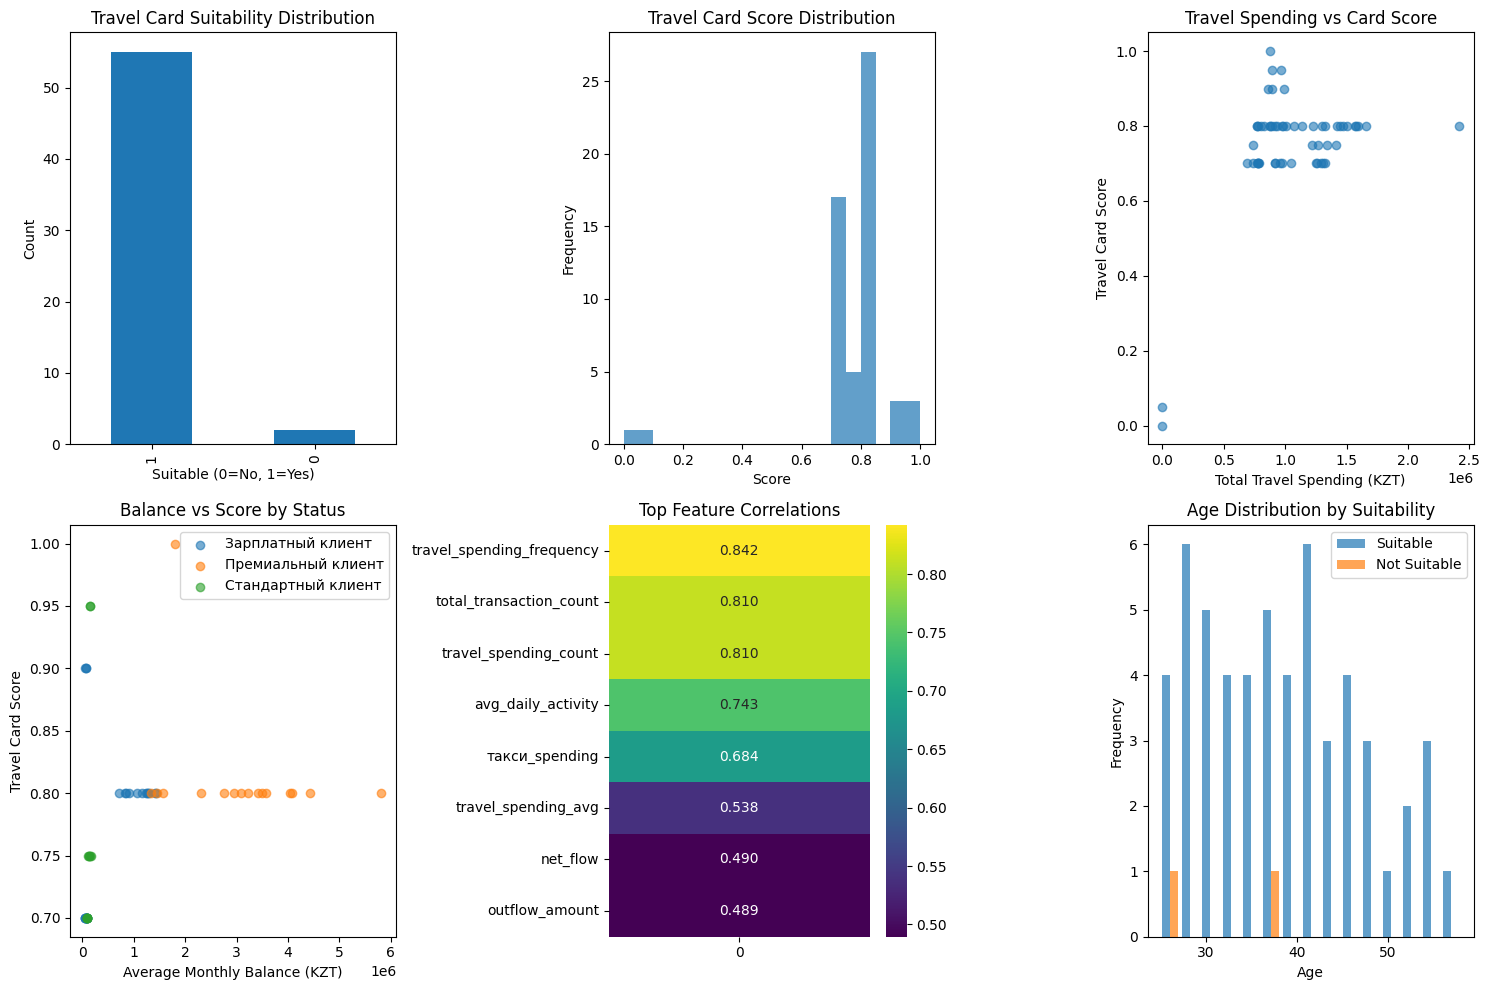


=== SUMMARY BY SUITABILITY ===
Statistics for suitable vs not suitable clients:


travel_spending_total                        \
                                      mean     median        std   
travel_card_suitable                                               
0                                      0.0       0.00       0.00   
1                                1094257.8  975835.08  325806.61   

                     travel_spending_count               fx_transaction_count  \
                                      mean median    std                 mean   
travel_card_suitable                                                            
0                                     0.00    0.0   0.00                 0.00   
1                                   122.89  125.0  12.78                 4.91   

                                   avg_monthly_balance_KZT            \
                     median    std                    mean    median   
travel_card_suitable                                                   
0                       0.0   0.00                94241.00   94241.0   
1                       0.0  14.16              1187134.95  712277.0   

                                    age               
                             std   mean median   std  
travel_card_suitable                                  
0                       30672.88  32.00   32.0  7.07  
1                     1445731.12  38.58   38.0  8.61


=== DATASET READY FOR TRAINING ===
Features (X): (57, 29)
Binary target (y_binary): (57,)
Score target (y_score): (57,)
Data types: {dtype('float64'): 22, dtype('int64'): 7}
Ready for machine learning models!


In [6]:
# Prepare Training Data and Exploratory Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

print("Preparing training dataset...")

# Select features for training (exclude identifiers and targets)
feature_columns = [col for col in client_df.columns 
                  if col not in ['client_code', 'status', 'travel_card_score', 'travel_card_suitable']]

# Prepare feature matrix
X = client_df[feature_columns].fillna(0)
y_binary = client_df['travel_card_suitable']  # Binary classification target
y_score = client_df['travel_card_score']      # Regression target

# Handle any remaining infinities
X = X.replace([np.inf, -np.inf], 0)

print(f"Training data shape: {X.shape}")
print(f"Features: {len(feature_columns)}")
print(f"Target distribution (binary): {y_binary.value_counts().to_dict()}")
print(f"Target distribution (score): Min={y_score.min():.2f}, Max={y_score.max():.2f}, Mean={y_score.mean():.2f}")

# Feature importance analysis
print("\n=== FEATURE CORRELATIONS WITH TARGET ===")
correlations = X.corrwith(y_score).abs().sort_values(ascending=False)
print("Top 10 features correlated with travel card score:")
for feat, corr in correlations.head(10).items():
    print(f"  {feat}: {corr:.3f}")

# Scale features for model training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for model validation
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X_scaled, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

X_train_reg, X_test_reg, y_train_score, y_test_score = train_test_split(
    X_scaled, y_score, test_size=0.3, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Visualizations
plt.figure(figsize=(15, 10))

# 1. Target distribution
plt.subplot(2, 3, 1)
client_df['travel_card_suitable'].value_counts().plot(kind='bar')
plt.title('Travel Card Suitability Distribution')
plt.xlabel('Suitable (0=No, 1=Yes)')
plt.ylabel('Count')

# 2. Score distribution
plt.subplot(2, 3, 2)
plt.hist(client_df['travel_card_score'], bins=20, alpha=0.7)
plt.title('Travel Card Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

# 3. Travel spending vs Score
plt.subplot(2, 3, 3)
plt.scatter(client_df['travel_spending_total'], client_df['travel_card_score'], alpha=0.6)
plt.title('Travel Spending vs Card Score')
plt.xlabel('Total Travel Spending (KZT)')
plt.ylabel('Travel Card Score')

# 4. Balance vs Score by Status
plt.subplot(2, 3, 4)
for status in client_df['status'].unique():
    if pd.notna(status):
        subset = client_df[client_df['status'] == status]
        plt.scatter(subset['avg_monthly_balance_KZT'], subset['travel_card_score'], 
                   label=status, alpha=0.6)
plt.title('Balance vs Score by Status')
plt.xlabel('Average Monthly Balance (KZT)')
plt.ylabel('Travel Card Score')
plt.legend()

# 5. Feature importance heatmap (top features)
plt.subplot(2, 3, 5)
top_features = correlations.head(8)
sns.heatmap(top_features.values.reshape(-1, 1), 
            yticklabels=top_features.index, 
            annot=True, fmt='.3f', cmap='viridis')
plt.title('Top Feature Correlations')

# 6. Age distribution by suitability
plt.subplot(2, 3, 6)
suitable_ages = client_df[client_df['travel_card_suitable'] == 1]['age']
not_suitable_ages = client_df[client_df['travel_card_suitable'] == 0]['age']
plt.hist([suitable_ages, not_suitable_ages], label=['Suitable', 'Not Suitable'], 
         alpha=0.7, bins=15)
plt.title('Age Distribution by Suitability')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Summary statistics by suitability
print("\n=== SUMMARY BY SUITABILITY ===")
summary_stats = client_df.groupby('travel_card_suitable')[
    ['travel_spending_total', 'travel_spending_count', 'fx_transaction_count', 
     'avg_monthly_balance_KZT', 'age']
].agg(['mean', 'median', 'std']).round(2)

print("Statistics for suitable vs not suitable clients:")
display(summary_stats)

print(f"\n=== DATASET READY FOR TRAINING ===")
print(f"Features (X): {X.shape}")
print(f"Binary target (y_binary): {y_binary.shape}")
print(f"Score target (y_score): {y_score.shape}")
print(f"Data types: {X.dtypes.value_counts().to_dict()}")
print("Ready for machine learning models!")

In [7]:
# Model Training and Evaluation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import os

print("Training machine learning models...")

# Create directory for saving models
os.makedirs('../model_data', exist_ok=True)

# ============================================================================
# 1. BINARY CLASSIFICATION MODEL (Travel Card Suitable: Yes/No)
# ============================================================================

print("\n=== BINARY CLASSIFICATION MODEL ===")

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced'
)

rf_classifier.fit(X_train, y_train_binary)

# Predictions
y_pred_binary = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate classification model
print("Classification Results:")
print(f"Accuracy: {accuracy_score(y_test_binary, y_pred_binary):.3f}")
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))

# Feature importance for classification
feature_importance_clf = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Classification):")
for _, row in feature_importance_clf.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# ============================================================================
# 2. REGRESSION MODEL (Travel Card Score: 0-1)
# ============================================================================

print("\n=== REGRESSION MODEL ===")

# Train Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5
)

rf_regressor.fit(X_train_reg, y_train_score)

# Predictions
y_pred_score = rf_regressor.predict(X_test_reg)

# Evaluate regression model
mse = mean_squared_error(y_test_score, y_pred_score)
mae = mean_absolute_error(y_test_score, y_pred_score)
r2 = r2_score(y_test_score, y_pred_score)

print("Regression Results:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.3f}")

# Feature importance for regression
feature_importance_reg = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Regression):")
for _, row in feature_importance_reg.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# ============================================================================
# 3. MODEL COMPARISON AND VALIDATION
# ============================================================================

print("\n=== MODEL VALIDATION ===")

# Create validation predictions on full dataset
full_pred_binary = rf_classifier.predict(X_scaled)
full_pred_score = rf_regressor.predict(X_scaled)
full_pred_proba = rf_classifier.predict_proba(X_scaled)[:, 1]

# Add predictions to client dataframe
results_df = client_df.copy()
results_df['predicted_suitable'] = full_pred_binary
results_df['predicted_score'] = full_pred_score
results_df['predicted_probability'] = full_pred_proba

# Model agreement analysis
agreement = (results_df['travel_card_suitable'] == results_df['predicted_suitable']).mean()
print(f"Model agreement with business logic: {agreement:.1%}")

# Score correlation
score_correlation = results_df['travel_card_score'].corr(results_df['predicted_score'])
print(f"Score correlation (actual vs predicted): {score_correlation:.3f}")

# ============================================================================
# 4. BUSINESS INSIGHTS AND RECOMMENDATIONS
# ============================================================================

print("\n=== BUSINESS INSIGHTS ===")

# High-confidence predictions
high_confidence_suitable = results_df[
    (results_df['predicted_suitable'] == 1) & 
    (results_df['predicted_probability'] > 0.8)
]

print(f"High-confidence travel card candidates: {len(high_confidence_suitable)}")
print(f"Average characteristics of high-confidence candidates:")
print(f"  - Travel spending: {high_confidence_suitable['travel_spending_total'].mean():,.0f} KZT")
print(f"  - Travel transactions: {high_confidence_suitable['travel_spending_count'].mean():.1f}")
print(f"  - FX transactions: {high_confidence_suitable['fx_transaction_count'].mean():.1f}")
print(f"  - Average balance: {high_confidence_suitable['avg_monthly_balance_KZT'].mean():,.0f} KZT")

# False positives and negatives analysis
false_positives = results_df[
    (results_df['travel_card_suitable'] == 0) & 
    (results_df['predicted_suitable'] == 1)
]

false_negatives = results_df[
    (results_df['travel_card_suitable'] == 1) & 
    (results_df['predicted_suitable'] == 0)
]

print(f"\nModel Analysis:")
print(f"False Positives: {len(false_positives)} ({len(false_positives)/len(results_df):.1%})")
print(f"False Negatives: {len(false_negatives)} ({len(false_negatives)/len(results_df):.1%})")

# ============================================================================
# 5. SAVE MODELS AND RESULTS
# ============================================================================

print("\n=== SAVING MODELS ===")

# Save trained models
joblib.dump(rf_classifier, '../model_data/travel_card_classifier.pkl')
joblib.dump(rf_regressor, '../model_data/travel_card_regressor.pkl')
joblib.dump(scaler, '../model_data/feature_scaler.pkl')

# Save feature importance
feature_importance_clf.to_csv('../model_data/feature_importance_classification.csv', index=False)
feature_importance_reg.to_csv('../model_data/feature_importance_regression.csv', index=False)

# Save results with predictions
results_df.to_csv('../model_data/travel_card_predictions.csv', index=False)

# Save feature names for future use
pd.DataFrame({'feature': feature_columns}).to_csv('../model_data/feature_names.csv', index=False)

print("Models and results saved to '../model_data/' directory")

# ============================================================================
# 6. FINAL SUMMARY
# ============================================================================

print("\n" + "="*50)
print("TRAVEL CARD MODEL TRAINING SUMMARY")
print("="*50)
print(f"Dataset: {len(client_df)} clients")
print(f"Features: {len(feature_columns)}")
print(f"Travel card suitable clients: {client_df['travel_card_suitable'].sum()} ({client_df['travel_card_suitable'].mean():.1%})")
print()
print("Model Performance:")
print(f"  Classification Accuracy: {accuracy_score(y_test_binary, y_pred_binary):.3f}")
print(f"  Regression R²: {r2:.3f}")
print(f"  Model Agreement: {agreement:.1%}")
print()
print("Key Features:")
for _, row in feature_importance_clf.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")
print()
print("Ready for production deployment!")

# Display top candidates for marketing
print("\n=== TOP 10 TRAVEL CARD CANDIDATES ===")
top_candidates = results_df.nlargest(10, 'predicted_probability')[
    ['client_code', 'travel_spending_total', 'fx_transaction_count', 
     'predicted_score', 'predicted_probability']
]
display(top_candidates)

Training machine learning models...

=== BINARY CLASSIFICATION MODEL ===
Classification Results:
Accuracy: 0.944

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.94      1.00      0.97        17

    accuracy                           0.94        18
   macro avg       0.47      0.50      0.49        18
weighted avg       0.89      0.94      0.92        18


Top 10 Most Important Features (Classification):
  travel_spending_frequency: 0.154
  такси_spending: 0.108
  outflow_amount: 0.108
  avg_daily_activity: 0.077
  net_flow: 0.077
  inflow_amount: 0.077
  кафе_и_рестораны_spending: 0.062
  total_transaction_count: 0.062
  азс_spending: 0.062
  total_transaction_amount: 0.053

=== REGRESSION MODEL ===
Regression Results:
Mean Squared Error: 0.0151
Mean Absolute Error: 0.0404
R² Score: 0.535

Top 10 Most Important Features (Regression):
  net_flow: 0.333
  avg_monthly_balance_KZT: 0.

,client_code,travel_spending_total,fx_transaction_count,predicted_score,predicted_probability
0,1,1322885.88,0,0.694867,1.0
1,2,1141283.85,0,0.793125,1.0
2,4,1305392.77,0,0.704167,1.0
3,5,1323202.16,0,0.795050,1.0
4,6,1268274.01,0,0.744717,1.0
5,7,880340.67,0,0.797383,1.0
6,8,986174.33,0,0.800000,1.0
7,9,804142.47,0,0.796000,1.0
8,10,916643.30,0,0.798250,1.0
9,11,830782.57,0,0.799000,1.0


In [9]:
# Test Examples for Travel Card Model
print("Creating test examples for model validation...")

# ============================================================================
# 1. CREATE TEST CLIENT SCENARIOS
# ============================================================================

# Example clients with different profiles
test_clients = [
    {
        'name': 'High Traveler',
        'age': 35,
        'avg_monthly_balance_KZT': 300000,
        'status_encoded': 3,  # Premium client
        'travel_spending_total': 150000,
        'travel_spending_count': 25,
        'travel_spending_avg': 6000,
        'travel_spending_frequency': 0.8,
        'путешествия_spending': 80000,
        'отели_spending': 40000,
        'такси_spending': 15000,
        'кафе_и_рестораны_spending': 10000,
        'развлечения_spending': 5000,
        'азс_spending': 0,
        'travel_transfer_count': 20,
        'travel_transfer_amount': 200000,
        'fx_transaction_count': 8,
        'fx_amount': 50000,
        'total_transaction_amount': 200000,
        'total_transaction_count': 100,
        'total_transfer_amount': 250000,
        'total_transfer_count': 30,
        'inflow_amount': 500000,
        'outflow_amount': 200000,
        'net_flow': 300000,
        'financial_activity_ratio': 2.5,
        'activity_days': 80,
        'avg_daily_activity': 1.6,
        'weekend_activity_ratio': 0.3,
        'vacation_activity_ratio': 0.4
    },
    {
        'name': 'Moderate Traveler',
        'age': 28,
        'avg_monthly_balance_KZT': 150000,
        'status_encoded': 2,  # Salary client
        'travel_spending_total': 60000,
        'travel_spending_count': 12,
        'travel_spending_avg': 5000,
        'travel_spending_frequency': 0.4,
        'путешествия_spending': 30000,
        'отели_spending': 20000,
        'такси_spending': 8000,
        'кафе_и_рестораны_spending': 2000,
        'развлечения_spending': 0,
        'азс_spending': 0,
        'travel_transfer_count': 8,
        'travel_transfer_amount': 80000,
        'fx_transaction_count': 3,
        'fx_amount': 15000,
        'total_transaction_amount': 100000,
        'total_transaction_count': 60,
        'total_transfer_amount': 120000,
        'total_transfer_count': 15,
        'inflow_amount': 200000,
        'outflow_amount': 100000,
        'net_flow': 100000,
        'financial_activity_ratio': 2.0,
        'activity_days': 60,
        'avg_daily_activity': 1.25,
        'weekend_activity_ratio': 0.25,
        'vacation_activity_ratio': 0.3
    },
    {
        'name': 'Business Traveler',
        'age': 42,
        'avg_monthly_balance_KZT': 500000,
        'status_encoded': 3,  # Premium client
        'travel_spending_total': 200000,
        'travel_spending_count': 35,
        'travel_spending_avg': 5714,
        'travel_spending_frequency': 0.7,
        'путешествия_spending': 120000,
        'отели_spending': 60000,
        'такси_spending': 15000,
        'кафе_и_рестораны_spending': 5000,
        'развлечения_spending': 0,
        'азс_spending': 0,
        'travel_transfer_count': 30,
        'travel_transfer_amount': 300000,
        'fx_transaction_count': 12,
        'fx_amount': 100000,
        'total_transaction_amount': 300000,
        'total_transaction_count': 120,
        'total_transfer_amount': 400000,
        'total_transfer_count': 40,
        'inflow_amount': 800000,
        'outflow_amount': 300000,
        'net_flow': 500000,
        'financial_activity_ratio': 2.67,
        'activity_days': 90,
        'avg_daily_activity': 1.78,
        'weekend_activity_ratio': 0.2,
        'vacation_activity_ratio': 0.5
    },
    {
        'name': 'Non-Traveler',
        'age': 24,
        'avg_monthly_balance_KZT': 80000,
        'status_encoded': 0,  # Student
        'travel_spending_total': 5000,
        'travel_spending_count': 2,
        'travel_spending_avg': 2500,
        'travel_spending_frequency': 0.1,
        'путешествия_spending': 0,
        'отели_spending': 0,
        'такси_spending': 3000,
        'кафе_и_рестораны_spending': 2000,
        'развлечения_spending': 0,
        'азс_spending': 0,
        'travel_transfer_count': 3,
        'travel_transfer_amount': 10000,
        'fx_transaction_count': 0,
        'fx_amount': 0,
        'total_transaction_amount': 40000,
        'total_transaction_count': 25,
        'total_transfer_amount': 20000,
        'total_transfer_count': 5,
        'inflow_amount': 100000,
        'outflow_amount': 40000,
        'net_flow': 60000,
        'financial_activity_ratio': 2.5,
        'activity_days': 30,
        'avg_daily_activity': 1.0,
        'weekend_activity_ratio': 0.4,
        'vacation_activity_ratio': 0.2
    },
    {
        'name': 'Occasional Traveler',
        'age': 31,
        'avg_monthly_balance_KZT': 120000,
        'status_encoded': 1,  # Standard client
        'travel_spending_total': 25000,
        'travel_spending_count': 6,
        'travel_spending_avg': 4167,
        'travel_spending_frequency': 0.3,
        'путешествия_spending': 15000,
        'отели_spending': 8000,
        'такси_spending': 2000,
        'кафе_и_рестораны_spending': 0,
        'развлечения_spending': 0,
        'азс_spending': 0,
        'travel_transfer_count': 5,
        'travel_transfer_amount': 30000,
        'fx_transaction_count': 1,
        'fx_amount': 5000,
        'total_transaction_amount': 50000,
        'total_transaction_count': 35,
        'total_transfer_amount': 40000,
        'total_transfer_count': 8,
        'inflow_amount': 150000,
        'outflow_amount': 50000,
        'net_flow': 100000,
        'financial_activity_ratio': 3.0,
        'activity_days': 45,
        'avg_daily_activity': 0.96,
        'weekend_activity_ratio': 0.3,
        'vacation_activity_ratio': 0.25
    }
]

# ============================================================================
# 2. PREPARE TEST DATA
# ============================================================================

# Convert to DataFrame and ensure all features are present
test_df = pd.DataFrame(test_clients)

# Ensure all features from training are present
for feature in feature_columns:
    if feature not in test_df.columns:
        test_df[feature] = 0

# Reorder columns to match training data
test_df = test_df[['name'] + feature_columns]

print(f"Created {len(test_df)} test clients:")
for _, client in test_df.iterrows():
    print(f"  - {client['name']}")

# ============================================================================
# 3. MAKE PREDICTIONS
# ============================================================================

print("\n=== MAKING PREDICTIONS ===")

# Prepare features (exclude name)
X_test_examples = test_df[feature_columns].fillna(0)
X_test_examples = X_test_examples.replace([np.inf, -np.inf], 0)

# Scale features using the saved scaler
X_test_scaled = scaler.transform(X_test_examples)

# Make predictions
pred_binary = rf_classifier.predict(X_test_scaled)
pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]
pred_score = rf_regressor.predict(X_test_scaled)

# Add predictions to results
test_results = test_df[['name']].copy()
test_results['predicted_suitable'] = pred_binary
test_results['predicted_probability'] = pred_proba
test_results['predicted_score'] = pred_score
test_results['recommendation'] = test_results['predicted_probability'].apply(
    lambda x: 'High Priority' if x > 0.8 else 'Medium Priority' if x > 0.6 else 'Low Priority' if x > 0.4 else 'No Offer'
)

# ============================================================================
# 4. DISPLAY RESULTS
# ============================================================================

print("\n=== PREDICTION RESULTS ===")
print("Client Recommendations:")
print("-" * 80)

for _, row in test_results.iterrows():
    print(f"Client: {row['name']}")
    print(f"  Suitable: {'YES' if row['predicted_suitable'] == 1 else 'NO'}")
    print(f"  Probability: {row['predicted_probability']:.3f}")
    print(f"  Score: {row['predicted_score']:.3f}")
    print(f"  Recommendation: {row['recommendation']}")
    print("-" * 40)

# ============================================================================
# 5. BUSINESS LOGIC COMPARISON
# ============================================================================

print("\n=== BUSINESS LOGIC COMPARISON ===")

# Calculate business logic scores for comparison
business_scores = []
for _, client in test_df.iterrows():
    score = 0
    
    # Travel spending component
    if client['travel_spending_total'] > 100000:
        score += 0.4
    elif client['travel_spending_total'] > 50000:
        score += 0.3
    elif client['travel_spending_total'] > 20000:
        score += 0.2
    elif client['travel_spending_total'] > 5000:
        score += 0.1
    
    # Travel activity component
    if client['travel_spending_count'] >= 20:
        score += 0.3
    elif client['travel_spending_count'] >= 10:
        score += 0.2
    elif client['travel_spending_count'] >= 5:
        score += 0.1
    
    # FX activity component
    if client['fx_transaction_count'] >= 5:
        score += 0.2
    elif client['fx_transaction_count'] >= 2:
        score += 0.1
    
    # Balance component
    if client['avg_monthly_balance_KZT'] > 200000:
        score += 0.1
    elif client['avg_monthly_balance_KZT'] > 100000:
        score += 0.05
    
    business_scores.append(min(score, 1.0))

test_results['business_logic_score'] = business_scores
test_results['business_logic_suitable'] = (test_results['business_logic_score'] >= 0.5).astype(int)

print("Comparison: ML Model vs Business Logic")
print("-" * 60)
for _, row in test_results.iterrows():
    ml_match = "✓" if row['predicted_suitable'] == row['business_logic_suitable'] else "✗"
    print(f"{row['name']:<20} | ML: {row['predicted_suitable']} | Logic: {row['business_logic_suitable']} | Match: {ml_match}")

# ============================================================================
# 6. HOW TO USE IN PRODUCTION
# ============================================================================

print("\n" + "="*60)
print("HOW TO USE THESE MODELS IN PRODUCTION")
print("="*60)
print("""
1. LOAD SAVED MODELS:
   scaler = joblib.load('model_data/feature_scaler.pkl')
   classifier = joblib.load('model_data/travel_card_classifier.pkl')
   regressor = joblib.load('model_data/travel_card_regressor.pkl')

2. PREPARE NEW CLIENT DATA:
   - Extract features using the same logic as in this notebook
   - Fill missing values with 0
   - Use exact same feature names and order

3. MAKE PREDICTIONS:
   X_new_scaled = scaler.transform(new_client_features)
   is_suitable = classifier.predict(X_new_scaled)[0]
   probability = classifier.predict_proba(X_new_scaled)[0][1]
   score = regressor.predict(X_new_scaled)[0]

4. BUSINESS DECISIONS:
   - probability > 0.8: High priority marketing campaign
   - probability > 0.6: Standard travel card offer
   - probability > 0.4: Monitor and re-evaluate in 3 months
   - probability <= 0.4: No offer currently
""")

# Save test results
test_results.to_csv('../model_data/test_predictions.csv', index=False)
print("Test results saved to '../model_data/test_predictions.csv'")

print("\n🎯 Models are ready for production deployment!")

Creating test examples for model validation...
Created 5 test clients:
  - High Traveler
  - Moderate Traveler
  - Business Traveler
  - Non-Traveler
  - Occasional Traveler

=== MAKING PREDICTIONS ===

=== PREDICTION RESULTS ===
Client Recommendations:
--------------------------------------------------------------------------------
Client: High Traveler
  Suitable: YES
  Probability: 0.590
  Score: 0.361
  Recommendation: Low Priority
----------------------------------------
Client: Moderate Traveler
  Suitable: YES
  Probability: 0.590
  Score: 0.359
  Recommendation: Low Priority
----------------------------------------
Client: Business Traveler
  Suitable: YES
  Probability: 0.590
  Score: 0.396
  Recommendation: Low Priority
----------------------------------------
Client: Non-Traveler
  Suitable: NO
  Probability: 0.360
  Score: 0.271
  Recommendation: No Offer
----------------------------------------
Client: Occasional Traveler
  Suitable: NO
  Probability: 0.490
  Score: 0.340
